# 고양이 수염 스티커 만들기
이미지에서 얼굴을 인식하고 얼굴에 스티커를 붙여보자.

## 0. 모듈 import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import dlib
import math
import cv2
import os

## 1. 스티커 구하기 or 만들기

이미지에 붙일 스티커를 구해보자.  

https://www.flaticon.com/free-icon/cat-whiskers_24674?term=cat%20nose&page=1&position=1

위 링크에서 고양이 수염을 받았다.  
한번 출력을 해보자.

이미지 위에 덧씌우면서 알파블렌딩을 할것이므로 알파값까지 함께 로드한다.

(512, 512, 4)


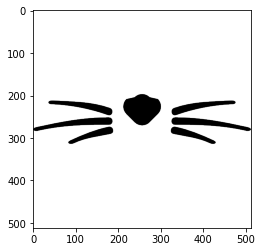

In [2]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png'
img_cat_whiskers = cv2.imread(sticker_path, cv2.IMREAD_UNCHANGED) # 알파값까지 읽어온다
print(img_cat_whiskers.shape)
plt.imshow(img_cat_whiskers)

스티커를 입힐 이미지도 출력해보자.

(450, 800, 3)


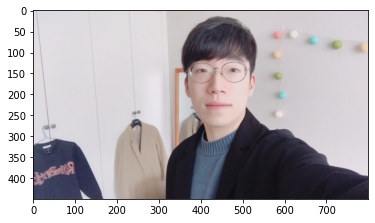

In [3]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/face.png'
img_src = cv2.imread(my_image_path)  # opencv는 기본 bgr순으로 로드한다.
print(img_src.shape)
plt.imshow(cv2.cvtColor(img_src, cv2.COLOR_BGR2RGB))

## 2. 얼굴 검출 & 랜드마크 검출 하기
우선 dlib로 얼굴의 바운딩 박스을 찾아보자.  
랜드마크를 표시할 이미지를 따로 복사해서 준비한다.

In [4]:
img_show = img_src.copy()  # 랜드마크를 그릴 더미 이미지
detector_hog = dlib.get_frontal_face_detector()
dlib_rect = detector_hog(img_show, 1)[0] # 이미지에서 얼굴을 찾아서 rect로 표시한다.

print(f"얼굴 영역 박스 : {dlib_rect}")

얼굴 영역 박스 : [(345, 98) (531, 284)]


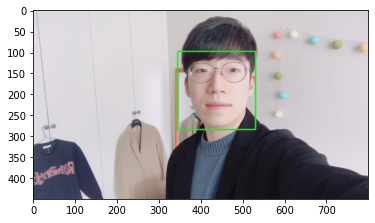

In [5]:
l = dlib_rect.left()
t = dlib_rect.top()
r = dlib_rect.right()
b = dlib_rect.bottom()

cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))

얼굴을 포함한 박스를 잘 찾았으니 이제, 랜드마크를 찾아서 그려보자.  
미리 준비한 68개짜리의 데이터셋 모델을 불러와 인식한 얼굴에 그려보자.

In [6]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path) # 68 랜드마크 모델

points = landmark_predictor(img_src, dlib_rect)
landmarks = list(map(lambda p: (p.x, p.y), points.parts()))
print(f"인식한 랜드마크 개수 : {len(landmarks)}")

인식한 랜드마크 개수 : 68


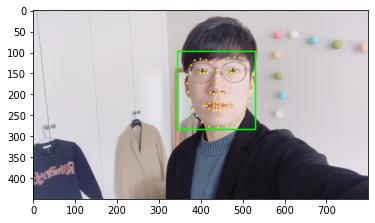

In [7]:
for idx, point in enumerate(landmarks):
    cv2.circle(img_show, point, 2, (0, 255, 255), -1)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))

## 3. 스티커 적용 위치 확인하기
고양이 수염을 기준으로 붙일 계획은 texture를 씌우듯이 적용 할 계획이다.

흔히 3d모델에 텍스쳐를 씌울 때는 3개의 버텍스로 삼각형(면)을 만들고 거기에 텍스쳐를 입힌다.  
보통 GUI나 3D HUD등의 사각형 이미지를 나타낼 때는 4개의 버텍스를 사용한다.

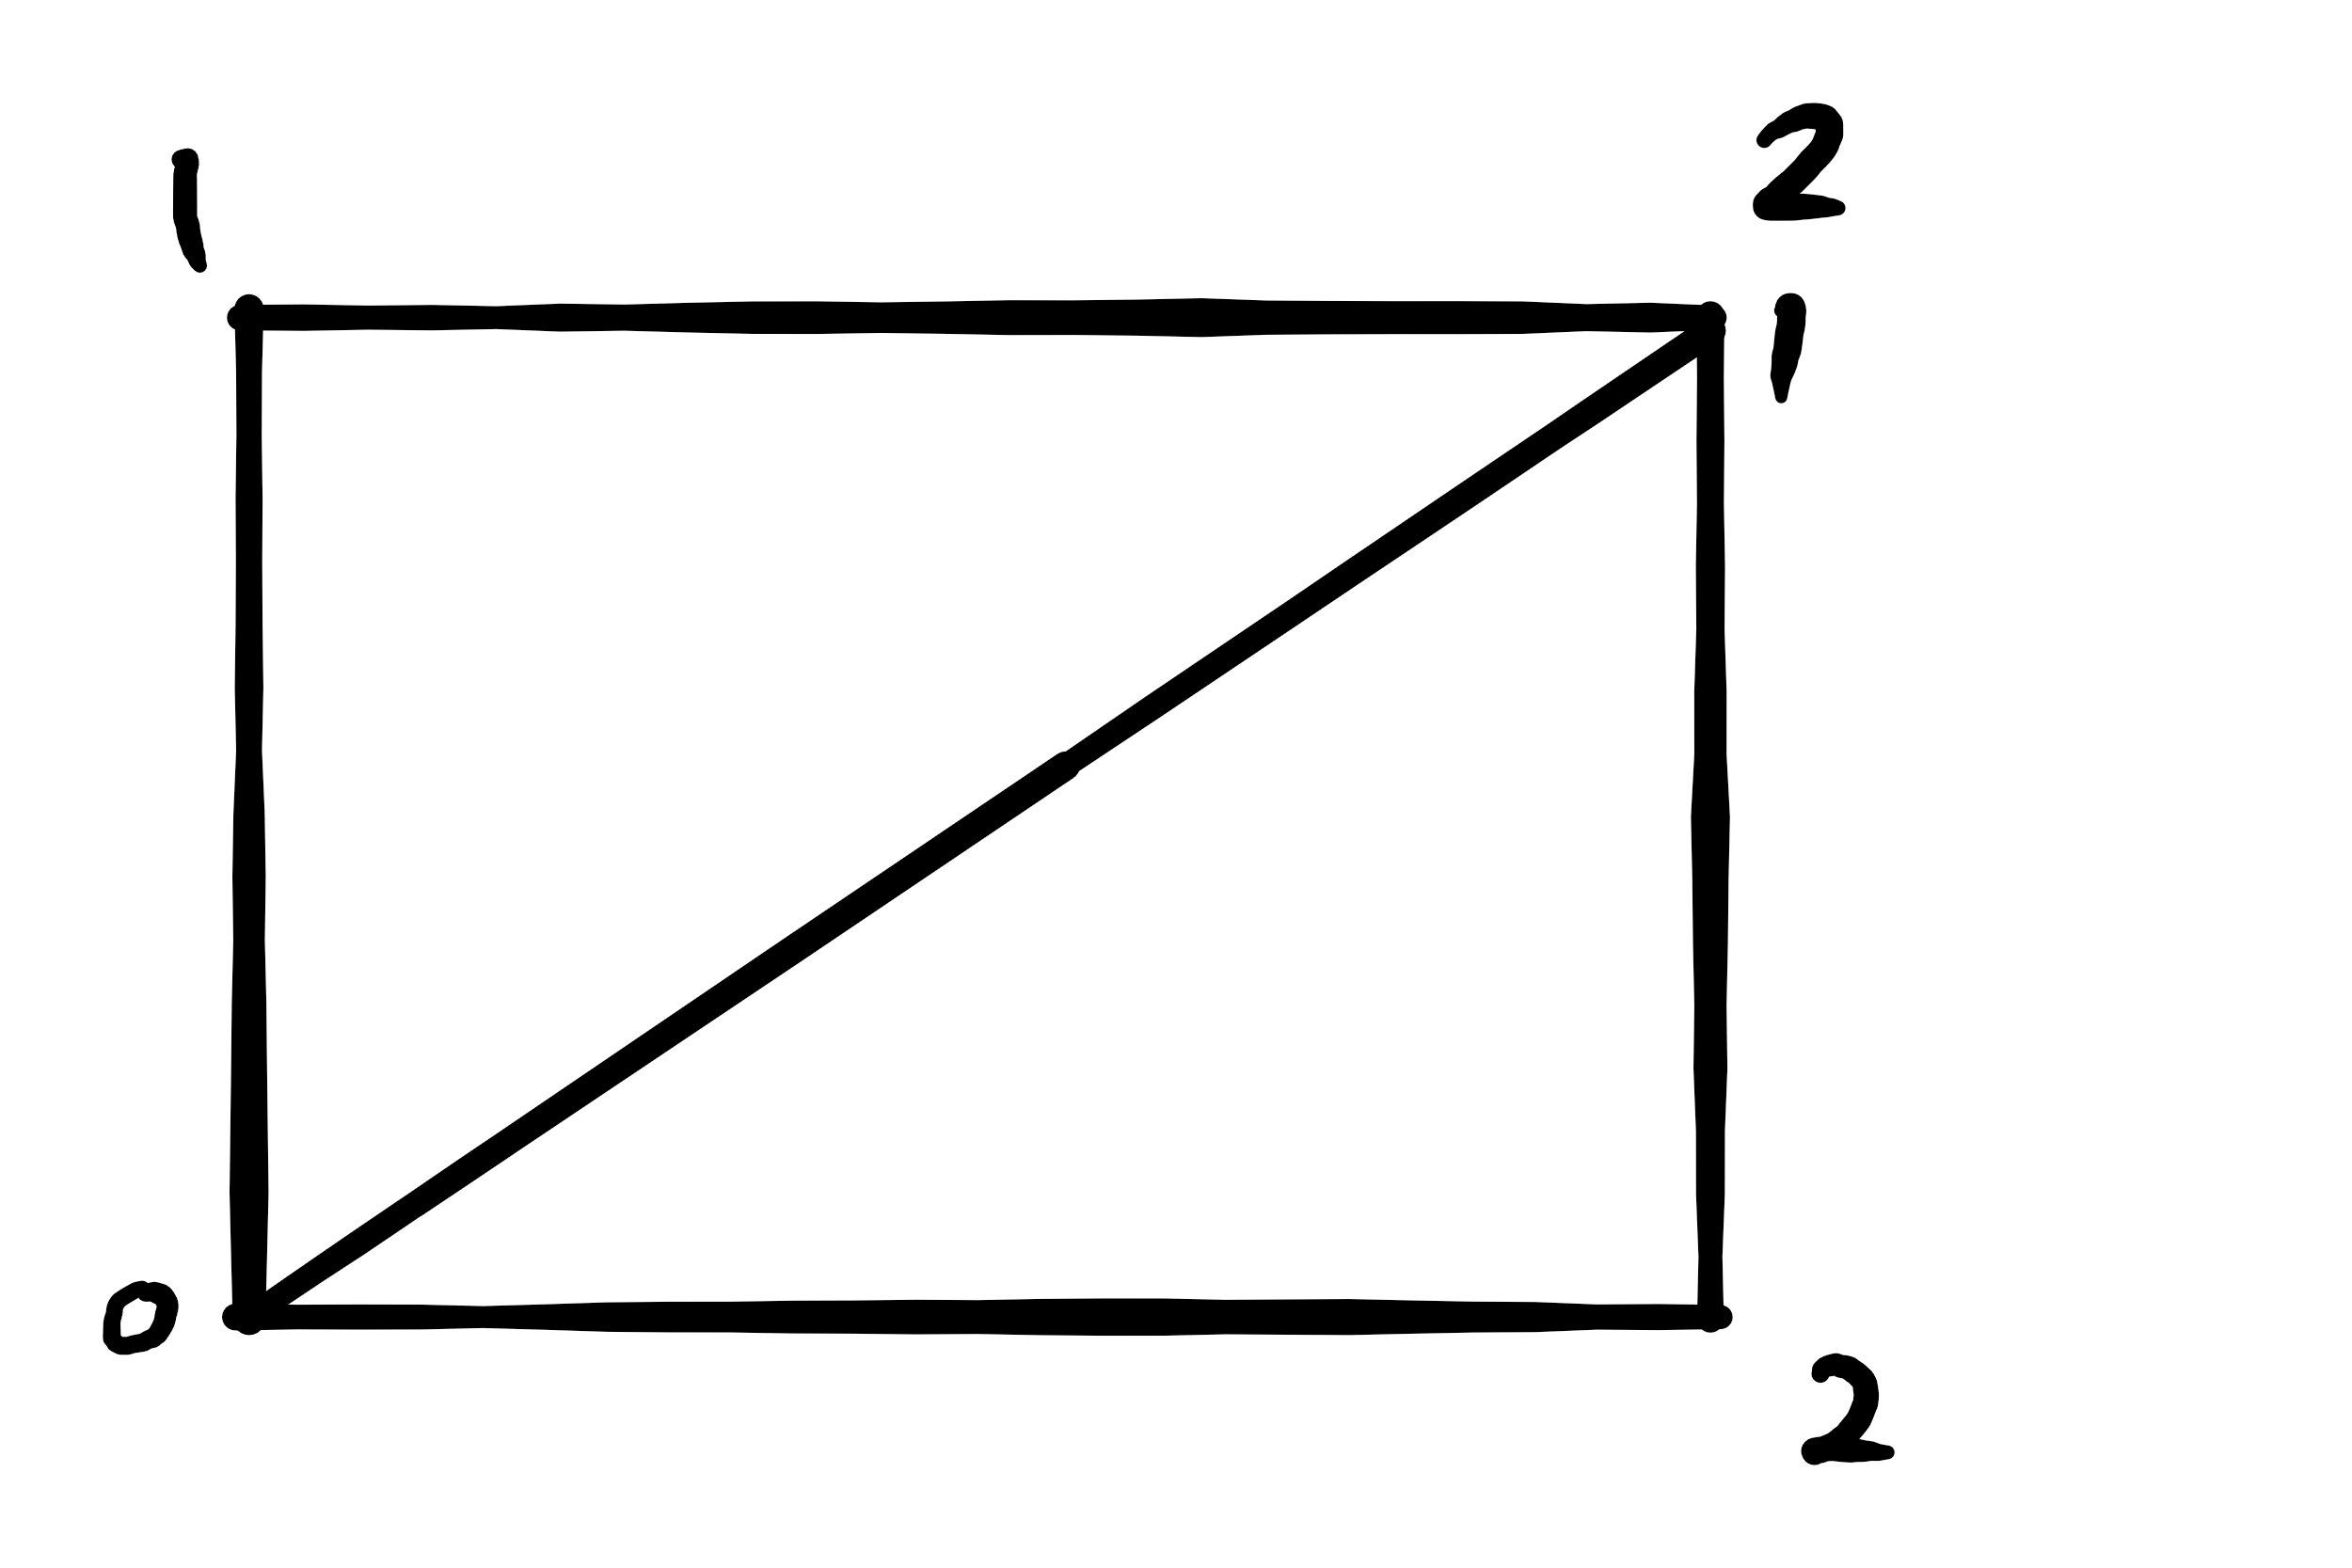

이렇게 하면 버텍스의 위치가 이동해서 사가형이 마름모로 찌그려져도 텍스쳐가 알맞게 잘 입혀진다.

그럼 다음으로 정면 랜드마크에서 어떤 사각형에 텍스쳐로 입힐지 결정해보자.

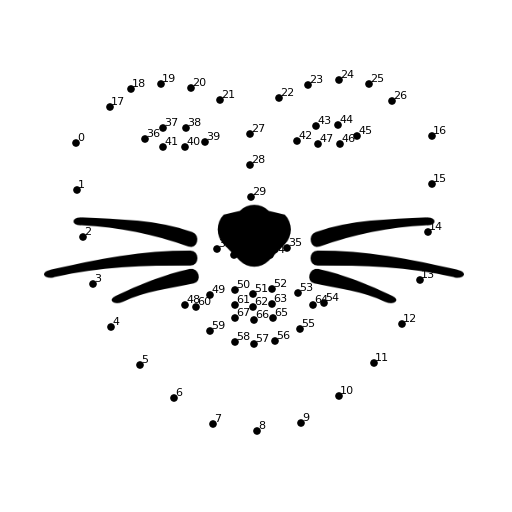
얼굴이 실제로는 3차원인것을 고려해서 왼쪽과 오른쪽을 나눠서 생각해보자.  
코와 인중 사이, 그리고 양 볼 끝을 버텍스로 폴리곤에 텍스쳐를 입히면 좋을것 같다.

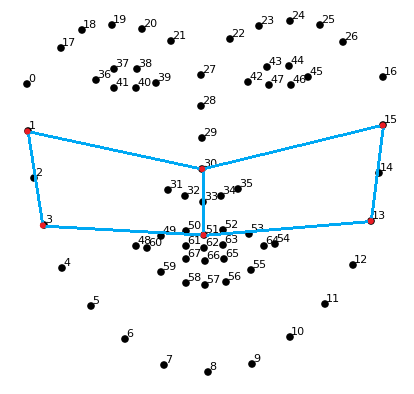
적당하게 양쪽 사각형을 잡았는데, 문제는 현재 수염이미지가 512 * 512로 정사각형에 얼굴을 완전 뒤덮는다.

그러므로 내가 원하는 폴리곤에 알맞게 이미지를 변경하자.   
다음 이미지는 수염을 반으로 나눠 입혀진 텍스쳐를 보기 쉽게 테두리를 넣었다.

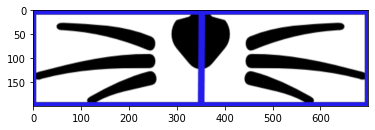

In [8]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat_whiskers_border.png'
img_whiskers_border = cv2.imread(sticker_path, cv2.IMREAD_UNCHANGED)
img_whiskers_border = cv2.resize(img_whiskers_border, (700,200)) # 정면의 랜드마크 폴리곤에 맞춰서 크기변경
plt.imshow(img_whiskers_border)

## 4. 스티커 적용하기

이제 텍스쳐를 입히기 위한 준비는 끝났다.

마지막으로 바뀐 면에 대한 transform matrix를 구해야 한다.  
현재의 버텍스들에서 바뀐 버텍스들로의 변환 행렬을 구해야하는데,  
다행히 찾아보니 opencv에 getPerspectiveTransform라는 함수로 트랜스폼을 구할 수 있다.

한가지 문제는 directX나 openGL의 그래픽 라이브러리 처럼 삼각형을 바로 그릴 수는 없고,  
그 삼각형을 감싸는 직사각형을 만들어서 이미지를 그려야한다.  
아래는 삼각형 두 개로 이루어진 변환된 텍스쳐를 화면에 그리는 과정을 도식화한 것이다.

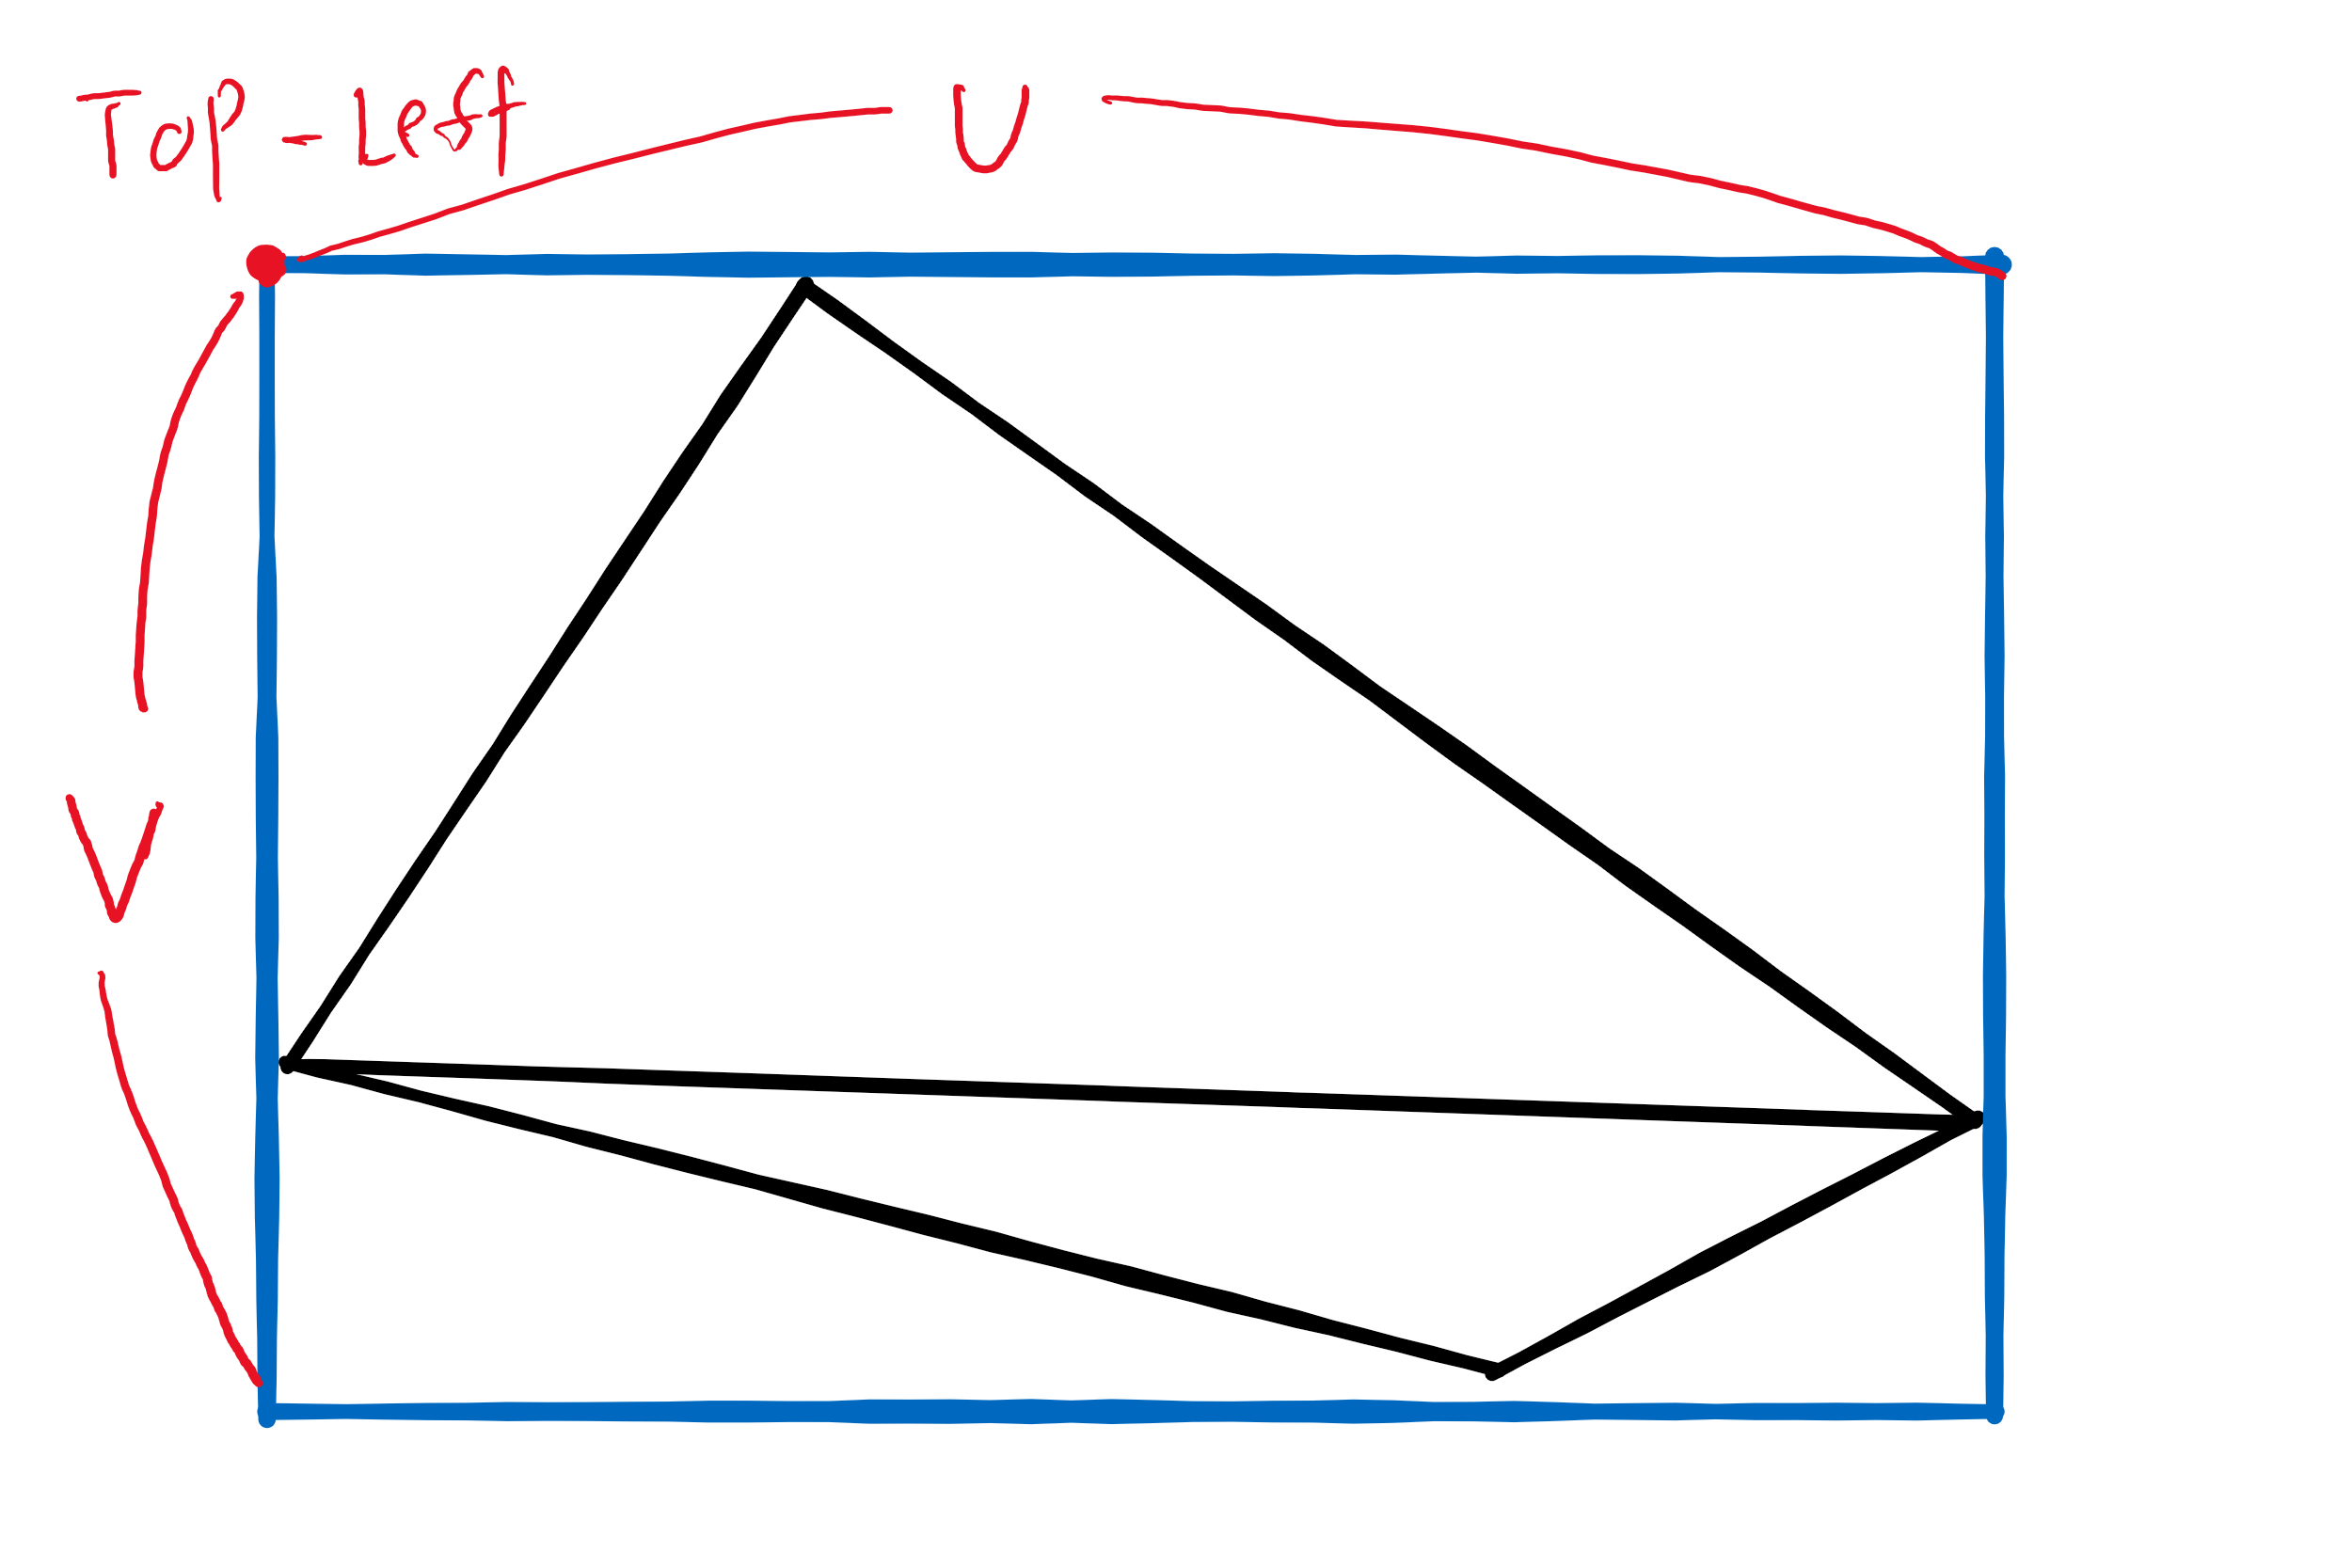

그럼 랜드마크에서 왼쪽 수염을 붙일 버텍스들을 구하고,  
그때 생기는 마름모를 감싸는 사각형의 top_left와 uv를 구해보자.

In [9]:
left_rect = np.zeros([4,2], dtype=np.float32)
left_rect[0] = landmarks[1]
left_rect[1] = landmarks[30]
left_rect[2] = landmarks[3]
left_rect[3] = landmarks[51]

top_left = np.min(left_rect, axis=0).astype(np.int32)
uv = np.max(left_rect, axis=0).astype(np.int32) - top_left

다음으로 아까 불러온 수염 이미지를 반으로 나눠놓자.

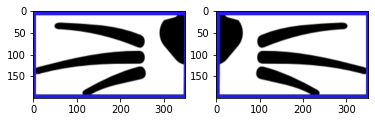

In [10]:
half = img_whiskers_border.shape[1] // 2
img_whiskers_left = img_whiskers_border[:,:half]
img_whiskers_right = img_whiskers_border[:,half:]


plt.subplot(121)
plt.imshow(img_whiskers_left)
 
plt.subplot(122)
plt.imshow(img_whiskers_right)

이제 transform matrix를 구해서 이미지를 입혀보자.  
계속해서 반복되는 계산을 할 것 같으므로 함수로 만들자.

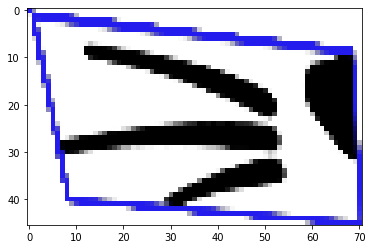

In [11]:
# 이미지를 바뀐 폴리곤에 맞춰서 계산해주는 함수
def calc_perspective_image(image, rect, uv):
    rect -= rect[0] # top left를 영점으로 맞춰준다.
    src_rect =np.float32([[0, 0], [image.shape[1], 0], [0, image.shape[0]],
                        [image.shape[1], image.shape[0]]])

    transform = cv2.getPerspectiveTransform(src_rect, rect) # 변환 매트릭스 얻기
    return cv2.warpPerspective(image, transform, uv.astype(np.int32)) # 이미지 변환


img_whiskers_left = calc_perspective_image(img_whiskers_left, left_rect, uv)
plt.imshow(img_whiskers_left)

마찬 가지로 계산된 텍스쳐 알파값에 맞춰 블랜딩해주는 함수를 만들자.

간단한 알파 블렌딩 공식은 blended = src * (1-α) + dst * α  이다.

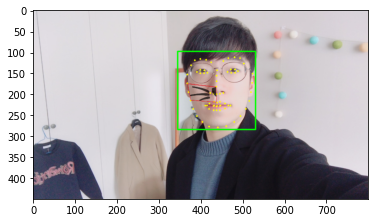

In [12]:
# 스티커 이미지를 위에 블랜드해주는 함수, alpha값을 인자로 받는다.
def blend_sticker(img_source, img_sticker, x, y, uv, alpha=1):
    x_si = max(0, x)
    x_ei = min(img_source.shape[1], x+uv[0])
    y_si = max(0, y)
    y_ei = min(img_source.shape[0], y+uv[1])

    y_e = y_ei-y-uv[1] if y_ei < y+uv[1] else None
    x_e = x_ei-x-uv[0] if x_ei < x+uv[0] else None

    alpha_mask = img_sticker[y_si-y:y_e, x_si-x:x_e, -1]/255
    alpha_mask = alpha_mask.reshape(alpha_mask.shape + (1,))
    img_sticker = img_sticker[y_si-y:y_e, x_si-x:x_e, :-1]

    sticker_area = img_source[y_si:y_ei, x_si:x_ei]
    img_source[y_si:y_ei, x_si:x_ei] = sticker_area*(1-alpha_mask*alpha) + img_sticker*alpha_mask*alpha
    
    
blend_sticker(img_show, img_whiskers_left, top_left[0], top_left[1], uv, alpha=0.7) # 투명도 0.3
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))

이제 양쪽 수염을 새로운 원본복사본에 적용시켜보자.

In [13]:
img_show = img_src.copy()  # 랜드마크를 그릴 더미 이미지
blend_sticker(img_show, img_whiskers_left, top_left[0], top_left[1], uv, alpha=0.6)

# 오른쪽 수염 위치 처리
right_rect = np.zeros([4,2], dtype=np.float32)
right_rect[0] = landmarks[30]
right_rect[1] = landmarks[15]
right_rect[2] = landmarks[51]
right_rect[3] = landmarks[13]

top_left_r = np.min(right_rect, axis=0).astype(np.int32)
uv_r = np.max(right_rect, axis=0).astype(np.int32) - top_left

img_whiskers_right = calc_perspective_image(img_whiskers_right, right_rect, uv_r)
blend_sticker(img_show, img_whiskers_right, top_left_r[0], top_left_r[1], uv_r, alpha=0.6)

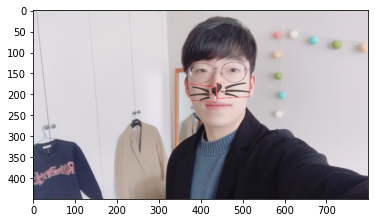

In [14]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))

## 5. 문제점

결과를 보면 딱봐표 텍스쳐의 위치가 잘못된걸 알 수 있다.  
몇가지 실험을 해본 결과 warpPerspective()함수가 반환하는 이미지의 크기는 맞췄지만,  
회전 변환을 하면서 top left를 기준으로 사각형을 만들면서 이런 문제가 생긴 것 같다.

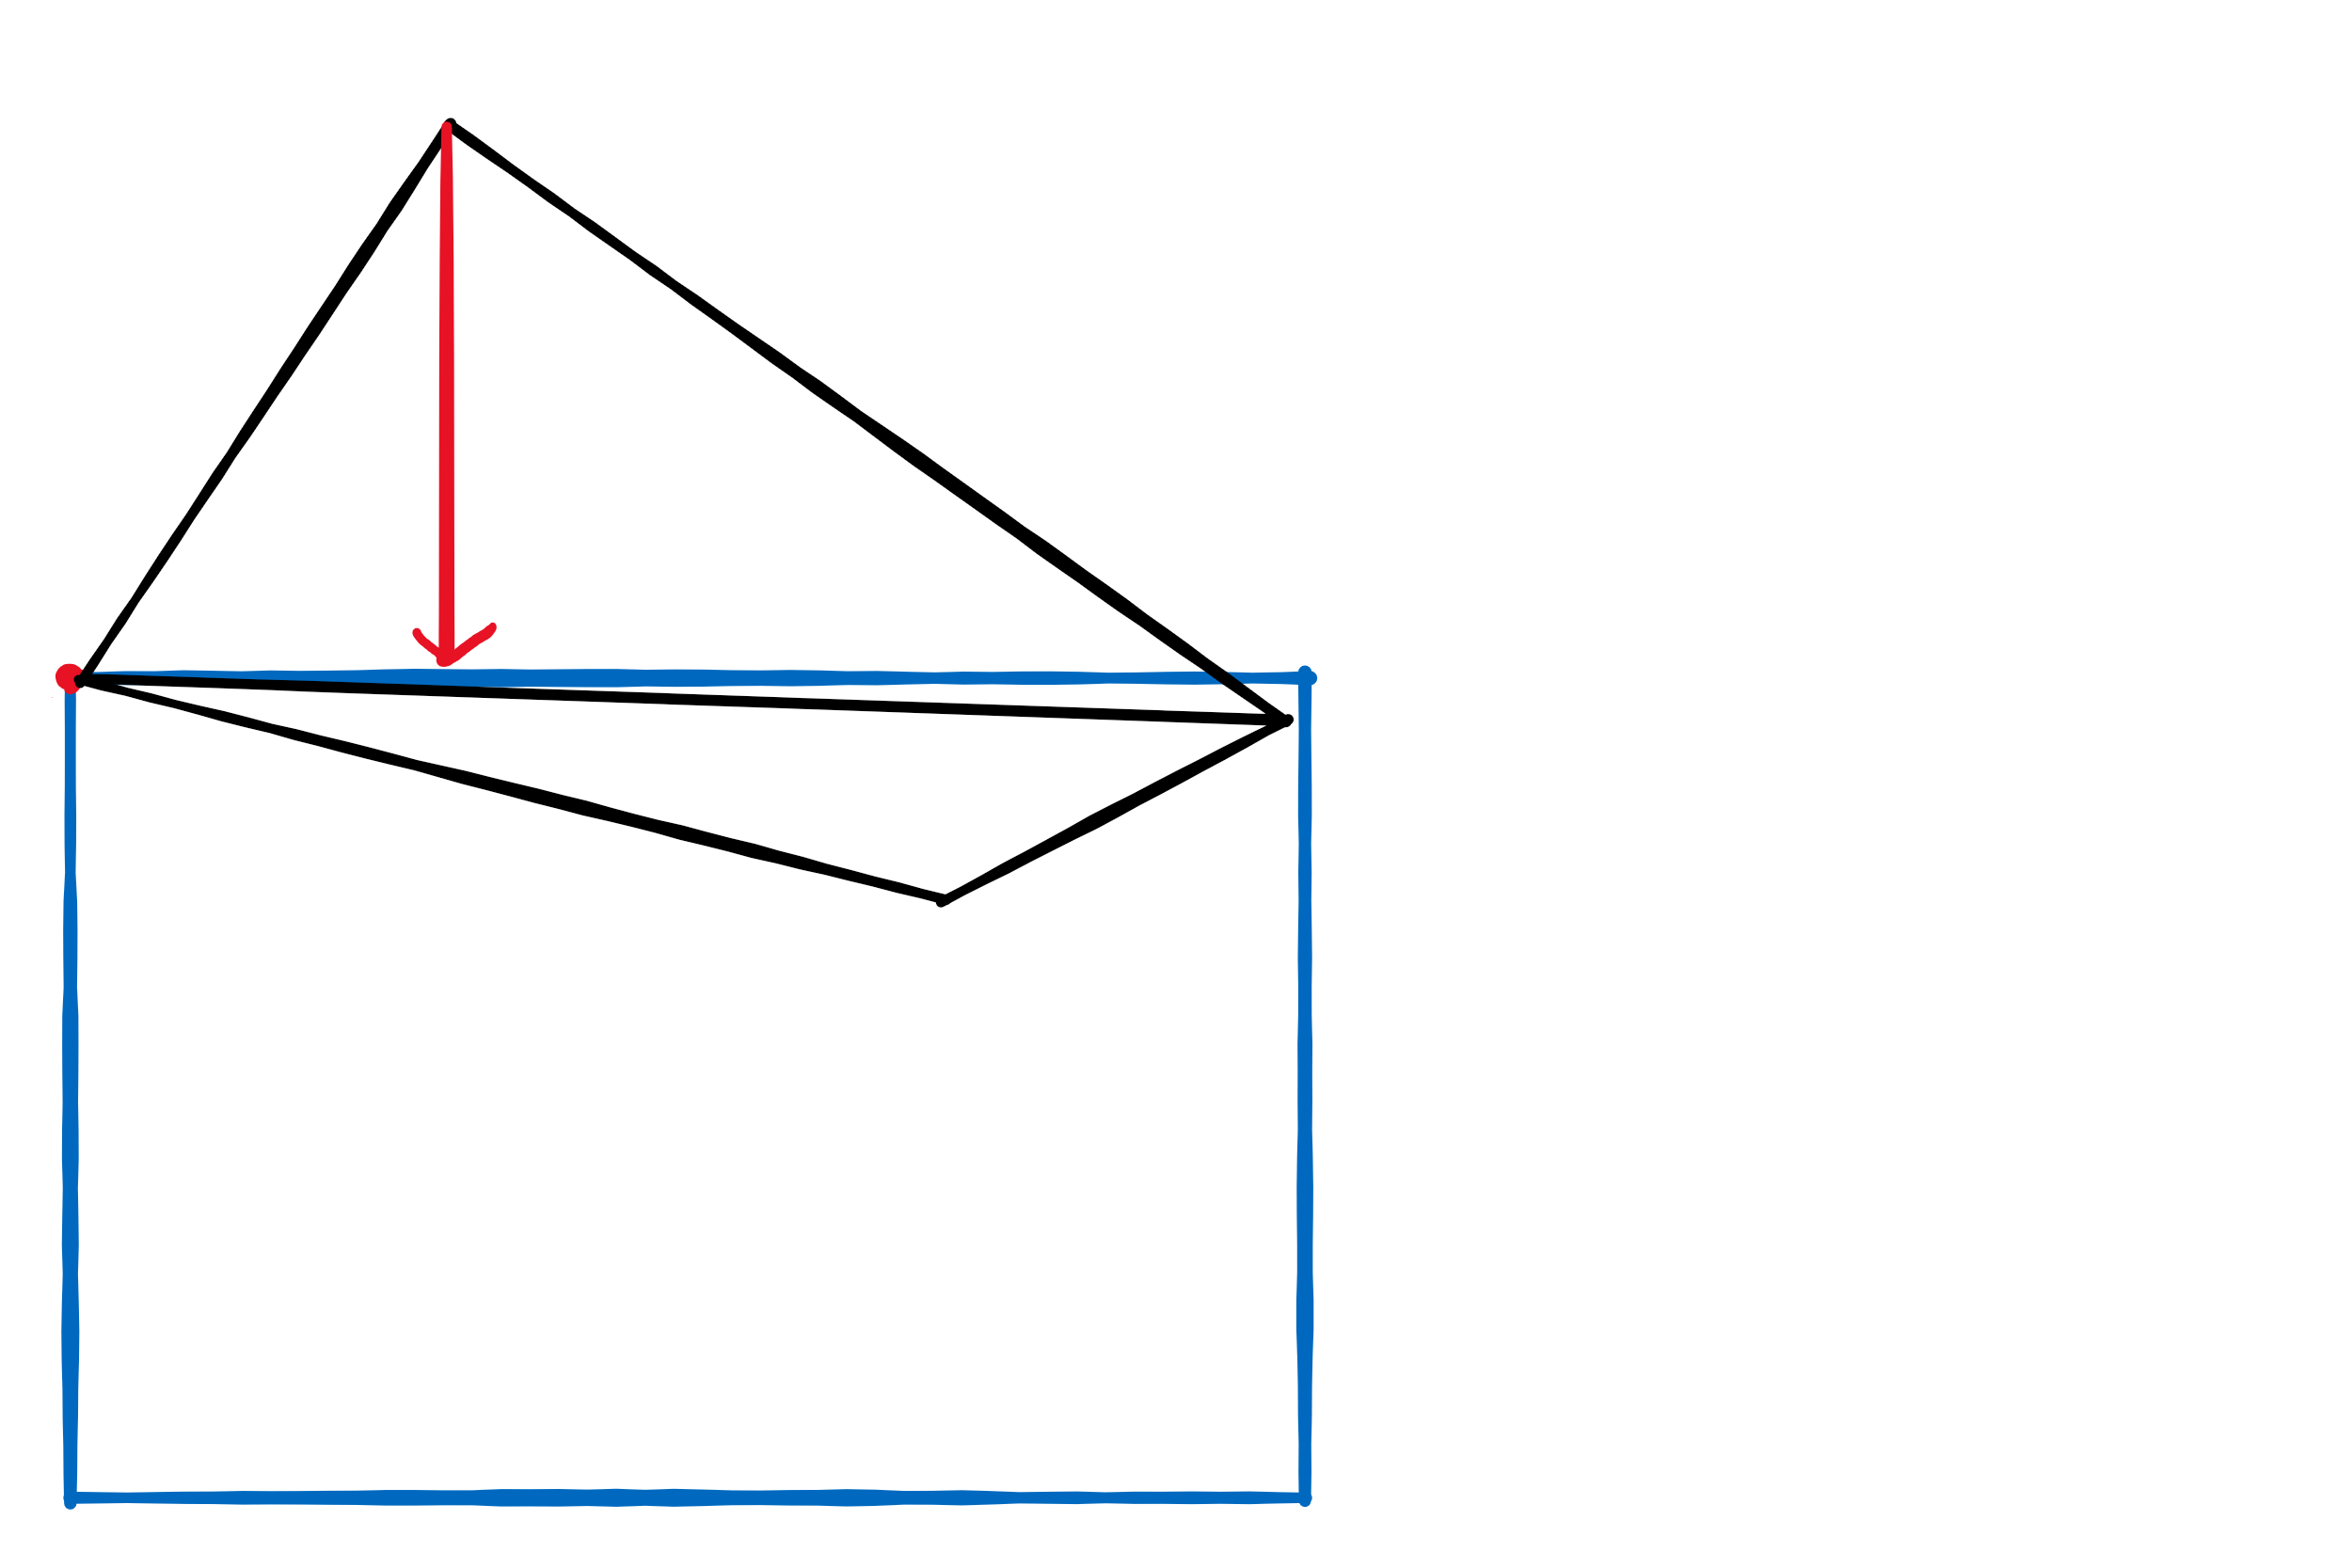
다행히 크기 문제가 없었기 때문에 SRT의 순서에 따라 이동 변환을  
추가로 해주어도 이미지가 깨질 걱정은 없다.

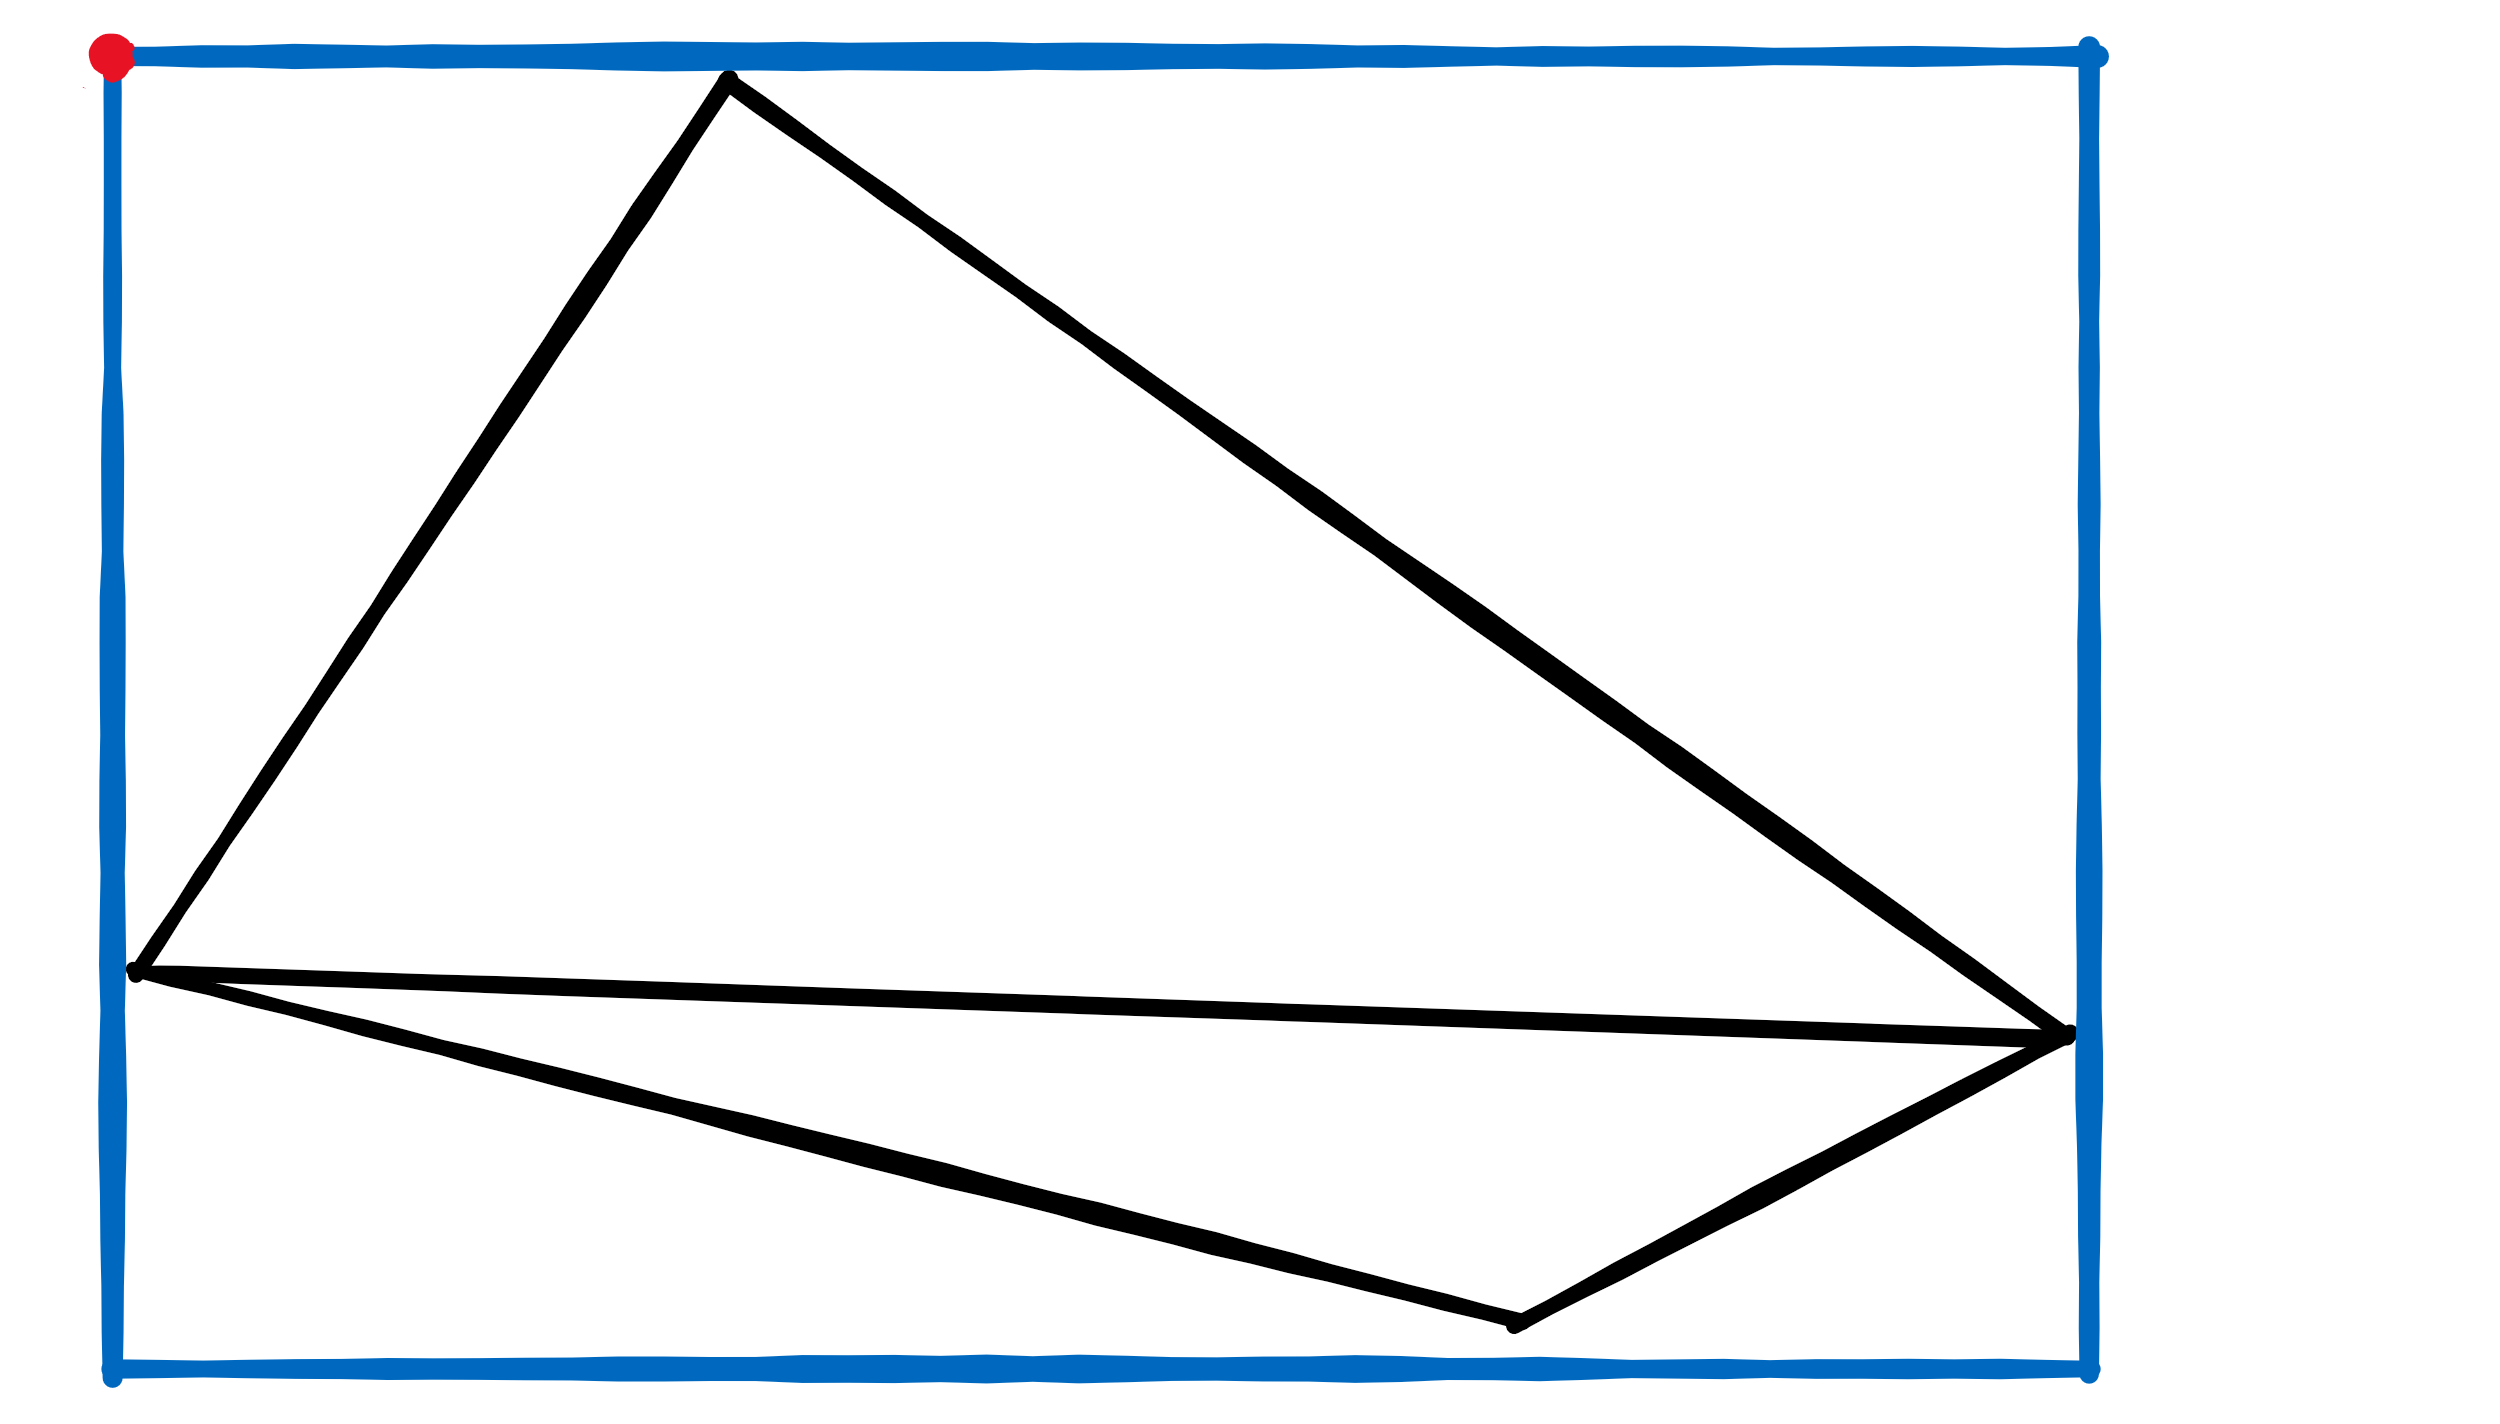
기존의 calc_perspective_image함수에서 회전하면서 생긴 거리만큼을 다시 평행이동 시켜준다.

변환 행렬은 내적으로 곱해진 순서대로 모든 변환을 실행한다.  
top_left에서 벗어난 거리만큼을 이동변환 행렬로 만들어 내적해준다.

In [15]:
# 이미지를 바뀐 폴리곤에 맞춰서 계산해주는 함수
def calc_perspective_image(image, rect, uv):
    rect -= rect[0]
    src_rect =np.float32([[0, 0], [image.shape[1], 0], [0, image.shape[0]],
                        [image.shape[1], image.shape[0]]])

    transform = cv2.getPerspectiveTransform(src_rect, rect)
    _top_left = np.min(rect, axis=0) # 범위 밖으로 빠져 나간부분

    # 이동 변환 행렬
    translate = np.eye(3)
    translate[0, 2] = -_top_left[0]
    translate[1, 2] = -_top_left[1]
    transform = np.dot(translate, transform) # 내적으로 모든 변환 뒤에 이동 변환해준다.
    
    return cv2.warpPerspective(image, transform, uv.astype(np.int32))

이제 다시 한번 얼굴에 그려보자.

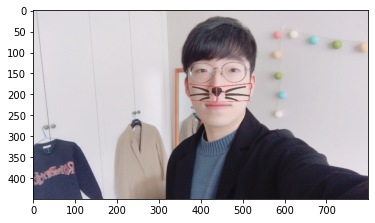

In [16]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat_whiskers_border.png'
img_whiskers_border = cv2.imread(sticker_path, cv2.IMREAD_UNCHANGED)
img_whiskers_border = cv2.resize(img_whiskers_border, (700,200)) # 정면의 랜드마크 폴리곤에 맞춰서 크기변경
half = img_whiskers_border.shape[1] // 2
img_whiskers_left = img_whiskers_border[:,:half]
img_whiskers_right = img_whiskers_border[:,half:]

img_show = img_src.copy()  # 랜드마크를 그릴 더미 이미지
img_whiskers_left = calc_perspective_image(img_whiskers_left, left_rect, uv)
blend_sticker(img_show, img_whiskers_left, top_left[0], top_left[1], uv, alpha=0.6)
img_whiskers_right = calc_perspective_image(img_whiskers_right, right_rect, uv_r)
blend_sticker(img_show, img_whiskers_right, top_left_r[0], top_left_r[1], uv_r, alpha=0.6)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))

이제 문제 없이 그려지는 것 같다.

## 6. 클래스로 만들기
앞에 있던 코드를 정리해서 하나의 클래스로 만들어보자.  
추가로 이미지에 왕관도 씌어보자.

In [17]:
class StickerMaker:
    def __init__(self) -> None:
        self.detector_hog = dlib.get_frontal_face_detector()

        model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
        self.landmark_predictor = dlib.shape_predictor(model_path)

        sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat_whiskers.png'
        img_cat_whiskers = cv2.imread(sticker_path, cv2.IMREAD_UNCHANGED)
        img_cat_whiskers = cv2.resize(img_cat_whiskers, (700,200))
        self.img_whiskers_left = img_cat_whiskers[:,:350]
        self.img_whiskers_right = img_cat_whiskers[:,350:]

        sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/king.png'
        self.img_crown = cv2.imread(sticker_path, cv2.IMREAD_UNCHANGED)


    def blend_with_tranform(self, draw_rect, img_src, img_dst, alpha):
        top_left = np.min(draw_rect, axis=0).astype(np.int32)
        uv = np.max(draw_rect, axis=0).astype(np.int32) - top_left

        img_sticker = calc_perspective_image(img_dst, draw_rect, uv)
        blend_sticker(img_src, img_sticker, int(top_left[0]), int(top_left[1]), uv, alpha=alpha)
        

    def draw_sticker_image(self, image, alpha):
        dlib_rects = self.detector_hog(image, 1)
        if len(dlib_rects) == 0:
            print(f"얼굴 영역을 사각형을 찾지못했습니다.")
            return
        else:
            dlib_rect = dlib_rects[0]
            print(f"얼굴 영역 좌표 {dlib_rect}")   # 찾은 얼굴영역 좌표

        points = self.landmark_predictor(image, dlib_rect)
        landmarks = list(map(lambda p: (p.x, p.y), points.parts()))
        print(f"인식한 랜드마크 개수 : {len(landmarks)}")

        draw_rect = np.zeros([4,2], dtype=np.float32)
        draw_rect[0] = landmarks[1]
        draw_rect[1] = landmarks[30]
        draw_rect[2] = landmarks[3]
        draw_rect[3] = landmarks[51]
        self.blend_with_tranform(draw_rect, image, self.img_whiskers_left, alpha)

        draw_rect[0] = landmarks[30]
        draw_rect[1] = landmarks[15]
        draw_rect[2] = landmarks[51]
        draw_rect[3] = landmarks[13]
        self.blend_with_tranform(draw_rect, image, self.img_whiskers_right, alpha)

        draw_rect[2] = landmarks[0]
        draw_rect[3] = landmarks[16]
        cross_v = draw_rect[3] - draw_rect[2]
        cross_h = np.array((cross_v[1], -cross_v[0]))
        draw_rect[0] = landmarks[27]
        draw_rect[1] = landmarks[28]
        draw_rect[1] = draw_rect[0] - draw_rect[1]
        ori = draw_rect[0] + 2*draw_rect[1]

        draw_rect[2] = ori - cross_v/2
        draw_rect[3] = ori + cross_v/2
        draw_rect[0] = draw_rect[2] + cross_h
        draw_rect[1] = draw_rect[3] + cross_h
        self.blend_with_tranform(draw_rect, image, self.img_crown, alpha)

이제 다른 여러 각도의 사진으로 테스트를 해보자.

얼굴 영역 좌표 [(44, 44) (151, 152)]
인식한 랜드마크 개수 : 68


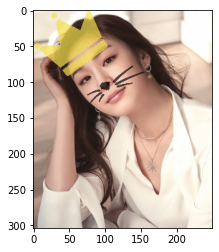

얼굴 영역 좌표 [(270, 98) (425, 253)]
인식한 랜드마크 개수 : 68


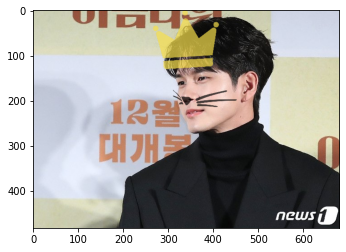

In [18]:
maker = StickerMaker()

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/face2.png'
img_bgr = cv2.imread(my_image_path) 
maker.draw_sticker_image(img_bgr, 0.7)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/face3.png'
img_bgr = cv2.imread(my_image_path) 
maker.draw_sticker_image(img_bgr, 0.7)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

방향에 맞게 깨지지 않고 스티커를 잘 출력하였다.

## 7. 문제점 찾아보기

 - 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?
 - 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?
 - 실행 속도가 중요할까요?
 - 스티커앱을 만들 때 정확도가 얼마나 중요할까요?

이미지의 크키와 변경하거나 회전시키면서 스티커를 그려보자.

얼굴 영역을 사각형을 찾지못했습니다.


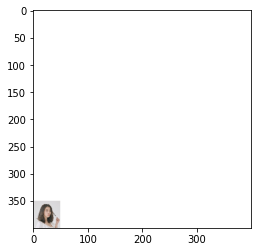

얼굴 영역 좌표 [(167, 125) (296, 254)]
인식한 랜드마크 개수 : 68


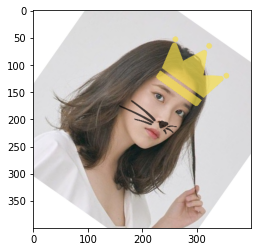

얼굴 영역을 사각형을 찾지못했습니다.


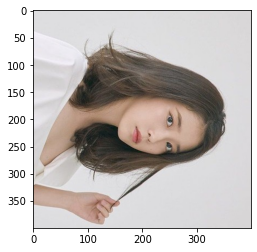

In [19]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/face4.png'
img_bgr = cv2.imread(my_image_path) 
maker.draw_sticker_image(img_bgr, 0.7)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/face5.png'
img_bgr = cv2.imread(my_image_path) 
maker.draw_sticker_image(img_bgr, 0.7)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/face6.png'
img_bgr = cv2.imread(my_image_path) 
maker.draw_sticker_image(img_bgr, 0.7)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

작은 이미지의 얼굴이나 일정이상으로 기울어진 이미지의 경우는  
얼굴 영역을 찾을 수 없었다.

이런 현상이 일어나는 이유가 dlib의 detect_hog 자체가  
기울어지지 않은 어느정도 이상의 이미지로만 학습시킨 결과이지 않을까 싶다.

### 개선사항
현재는 이미지를 인식한 얼굴 표면에 텍스쳐를 입히듯이 만들다 보니  
옆 모습에서 살짝 어색한 부분이 있다.

스티커 자체가 실제 3차원의 얼굴에 딱 붙은게 아니라 살짝 얼굴 앞에 떠있는  
3D HUD라고 생각하면, 스티커를 입힐 사각형을 조금 앞으로 이동 시켜야 할 것 같다.

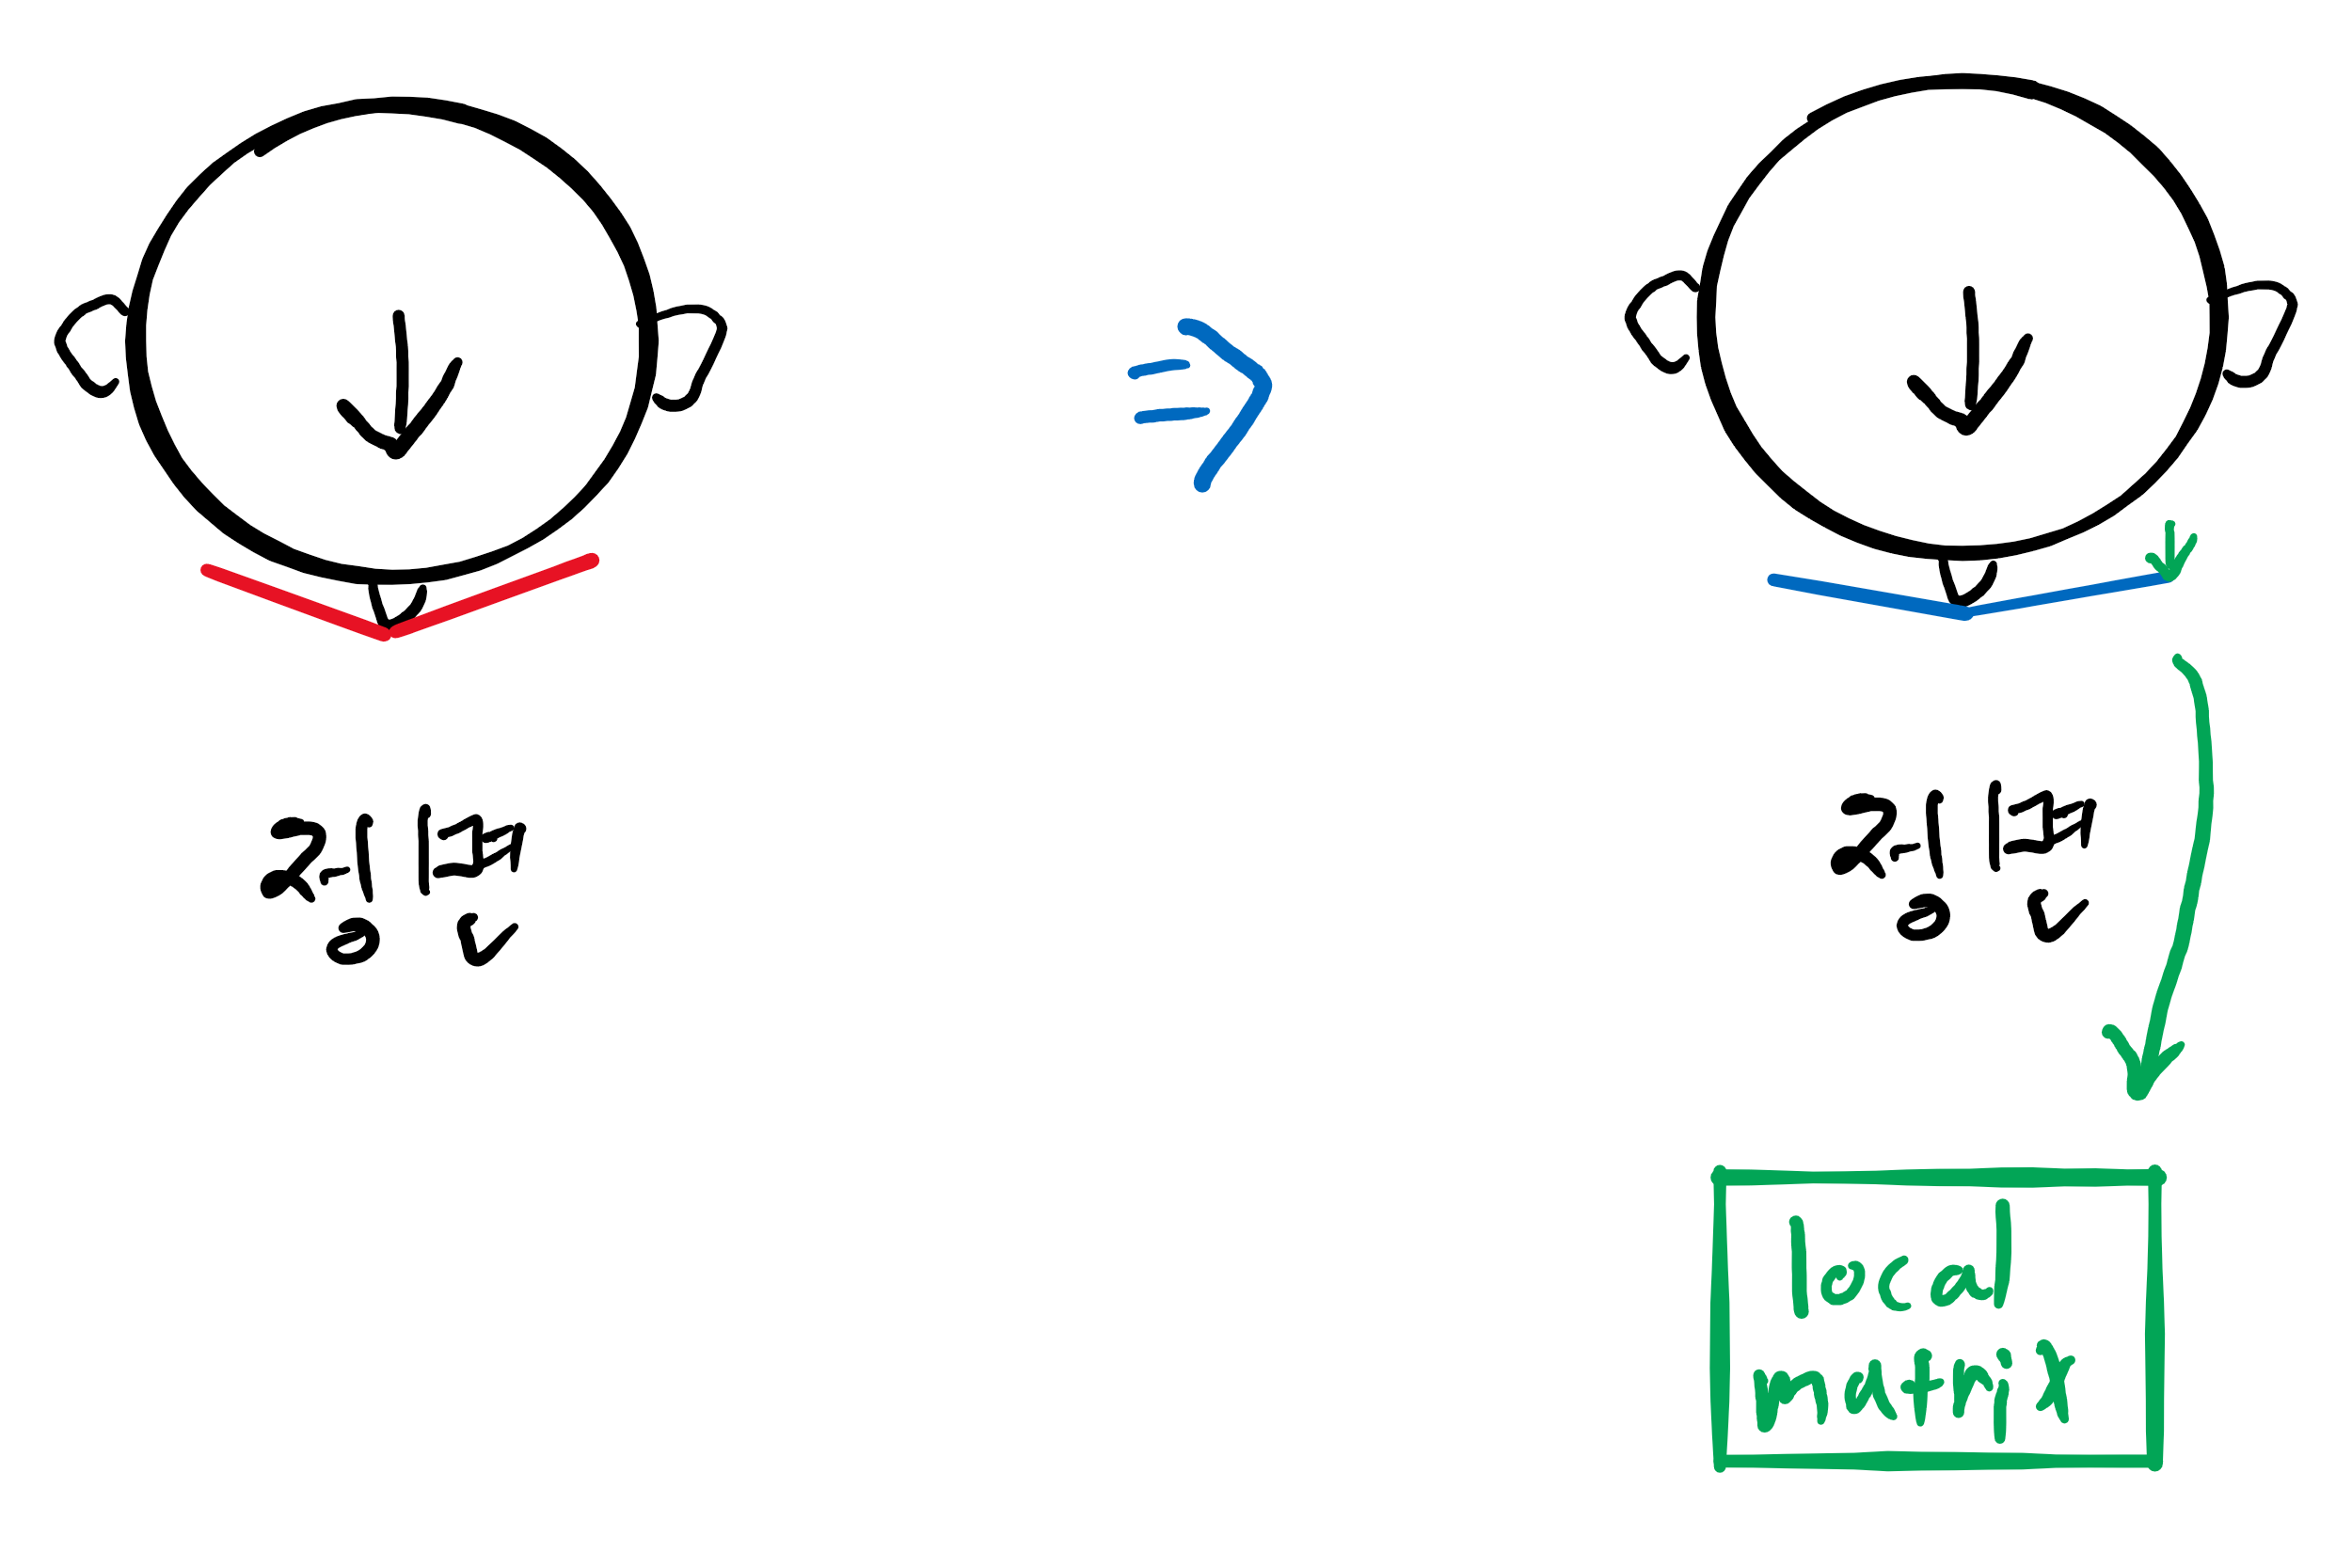

애초에 정면 이미지 자체가 2d라서 완전히 볼에 붙은 상태는 아니지만, 여전히 너무 볼에 붙어있다.

그림처럼 앞으로 이동시켜주는 변환행렬에다 이미지의 변환행렬을 내적해주는 순서로 계산하면,  
자연스러운 이미지가 나올 것 같다.

### 실행속도
현재는 단순히 입력으로 이미지를 받아서 스티커를 블랜한 이미지를 출력할 뿐이다.

하지만 실제 스티커 앱을 만든 다면 매 프레임 마다 작업을 반복해야한다.  
openGL이나 directX등의 그래픽 라이브러리를 사용한다면 텍스쳐 수백개를 그려도  
속도에는 별로 문제가 되지않을 것이다.

좀 더 빠른 속도를 위해서는 각 스티커의 정면얼굴의 root으로 부터의 변환 행렬을 미리 구해놓고,  
매 프레임마다 얼굴 root의 변환행렬만 구해서 곱해주면 계산이 빨라질 것 같다.

## 8. 회고

이번 exploration을 하면서 얼굴을 인식하는 모델보다는 모델로 인식된 얼굴에  
2차원 이미지에 그리는 것에 너무 집중해버렸다.

나중에라도 얼굴을 이미지에서 얼굴을 인식하는 모델에 대해 공부를 해야할 것 같다.

그래도 오랜만에 잘 아는 분야의 내용이 나와서 즐겁게 만들었던 것 같다.